In [1]:
!rm -rf * .* 2>/dev/null
!rm -rf ~/.kaggle && mkdir ~/.kaggle
!echo eyJ1c2VybmFtZSI6InB2dHNlYzB4MSIsImtleSI6IjZlOTYxZmMxYjdhYzU2OTlmNzcwYmFjMjI1NTk4MWIwIn0= | base64 -d > ~/.kaggle/kaggle.json
!git clone https://github.com/Reshmavineesh/SunLit-Segmentation .
!git checkout dev
!./download_dataset.sh
from IPython.display import clear_output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'; clear_output()
print("Dataset ready")

Dataset ready


In [2]:
import utils
import tensorflow as tf

image_path = 'dataset/dataset_tomato_128/color_images/'
mask_path = 'dataset/dataset_tomato_128/masks/'
n_val = 200

train_images, train_masks, test_images, test_masks = utils.load_dataset(image_path, mask_path, n_val)
print(f"Train Images:\t{train_images.shape}")
print(f"Train Masks:\t{train_masks.shape}")
print(f"Test Images:\t{test_images.shape}")
print(f"Test Masks:\t{test_masks.shape}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train Images:	(4648, 128, 128, 3)
Train Masks:	(4648, 128, 128)
Test Images:	(4648, 128, 128, 3)
Test Masks:	(4648, 128, 128)


In [3]:
from keras_models.models import FCDN103
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss=utils.dice_loss
metrics = ['accuracy']
input_shape = train_images.shape[1:]

train_attr = {
    "lr": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "optimizer": optimizer.get_config()['name'],
    "loss_fn": loss.get_config()['name']
}

n_layers_per_block = [4, 5, 7, 10, 12, 15]
n_classes = 1

model = FCDN103(n_classes, input_shape, num_layers_per_block=n_layers_per_block, dropout_rate=0.2, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train_images,
                    train_masks,
                    validation_split = 0.4,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks=[early_stopper])

Epoch 1/200
175/175 [==============================] - 187s 484ms/step - loss: 0.7653 - accuracy: 0.7746 - val_loss: 0.5900 - val_accuracy: 0.7949
Epoch 2/200
175/175 [==============================] - 75s 426ms/step - loss: 0.5059 - accuracy: 0.8143 - val_loss: 0.8689 - val_accuracy: 0.7611
Epoch 3/200
175/175 [==============================] - 75s 427ms/step - loss: 0.4744 - accuracy: 0.8175 - val_loss: 0.4851 - val_accuracy: 0.8106
Epoch 4/200
175/175 [==============================] - 75s 426ms/step - loss: 0.4620 - accuracy: 0.8206 - val_loss: 0.9342 - val_accuracy: 0.7511
Epoch 5/200
175/175 [==============================] - 75s 427ms/step - loss: 0.4561 - accuracy: 0.8228 - val_loss: 0.3966 - val_accuracy: 0.8041
Epoch 6/200
175/175 [==============================] - 75s 427ms/step - loss: 0.4515 - accuracy: 0.8229 - val_loss: 0.3941 - val_accuracy: 0.8020
Epoch 7/200
175/175 [==============================] - 75s 426ms/step - loss: 0.4470 - accuracy: 0.8234 - val_loss: 0.9924 

1/1 [==============================] - 0s 31ms/step


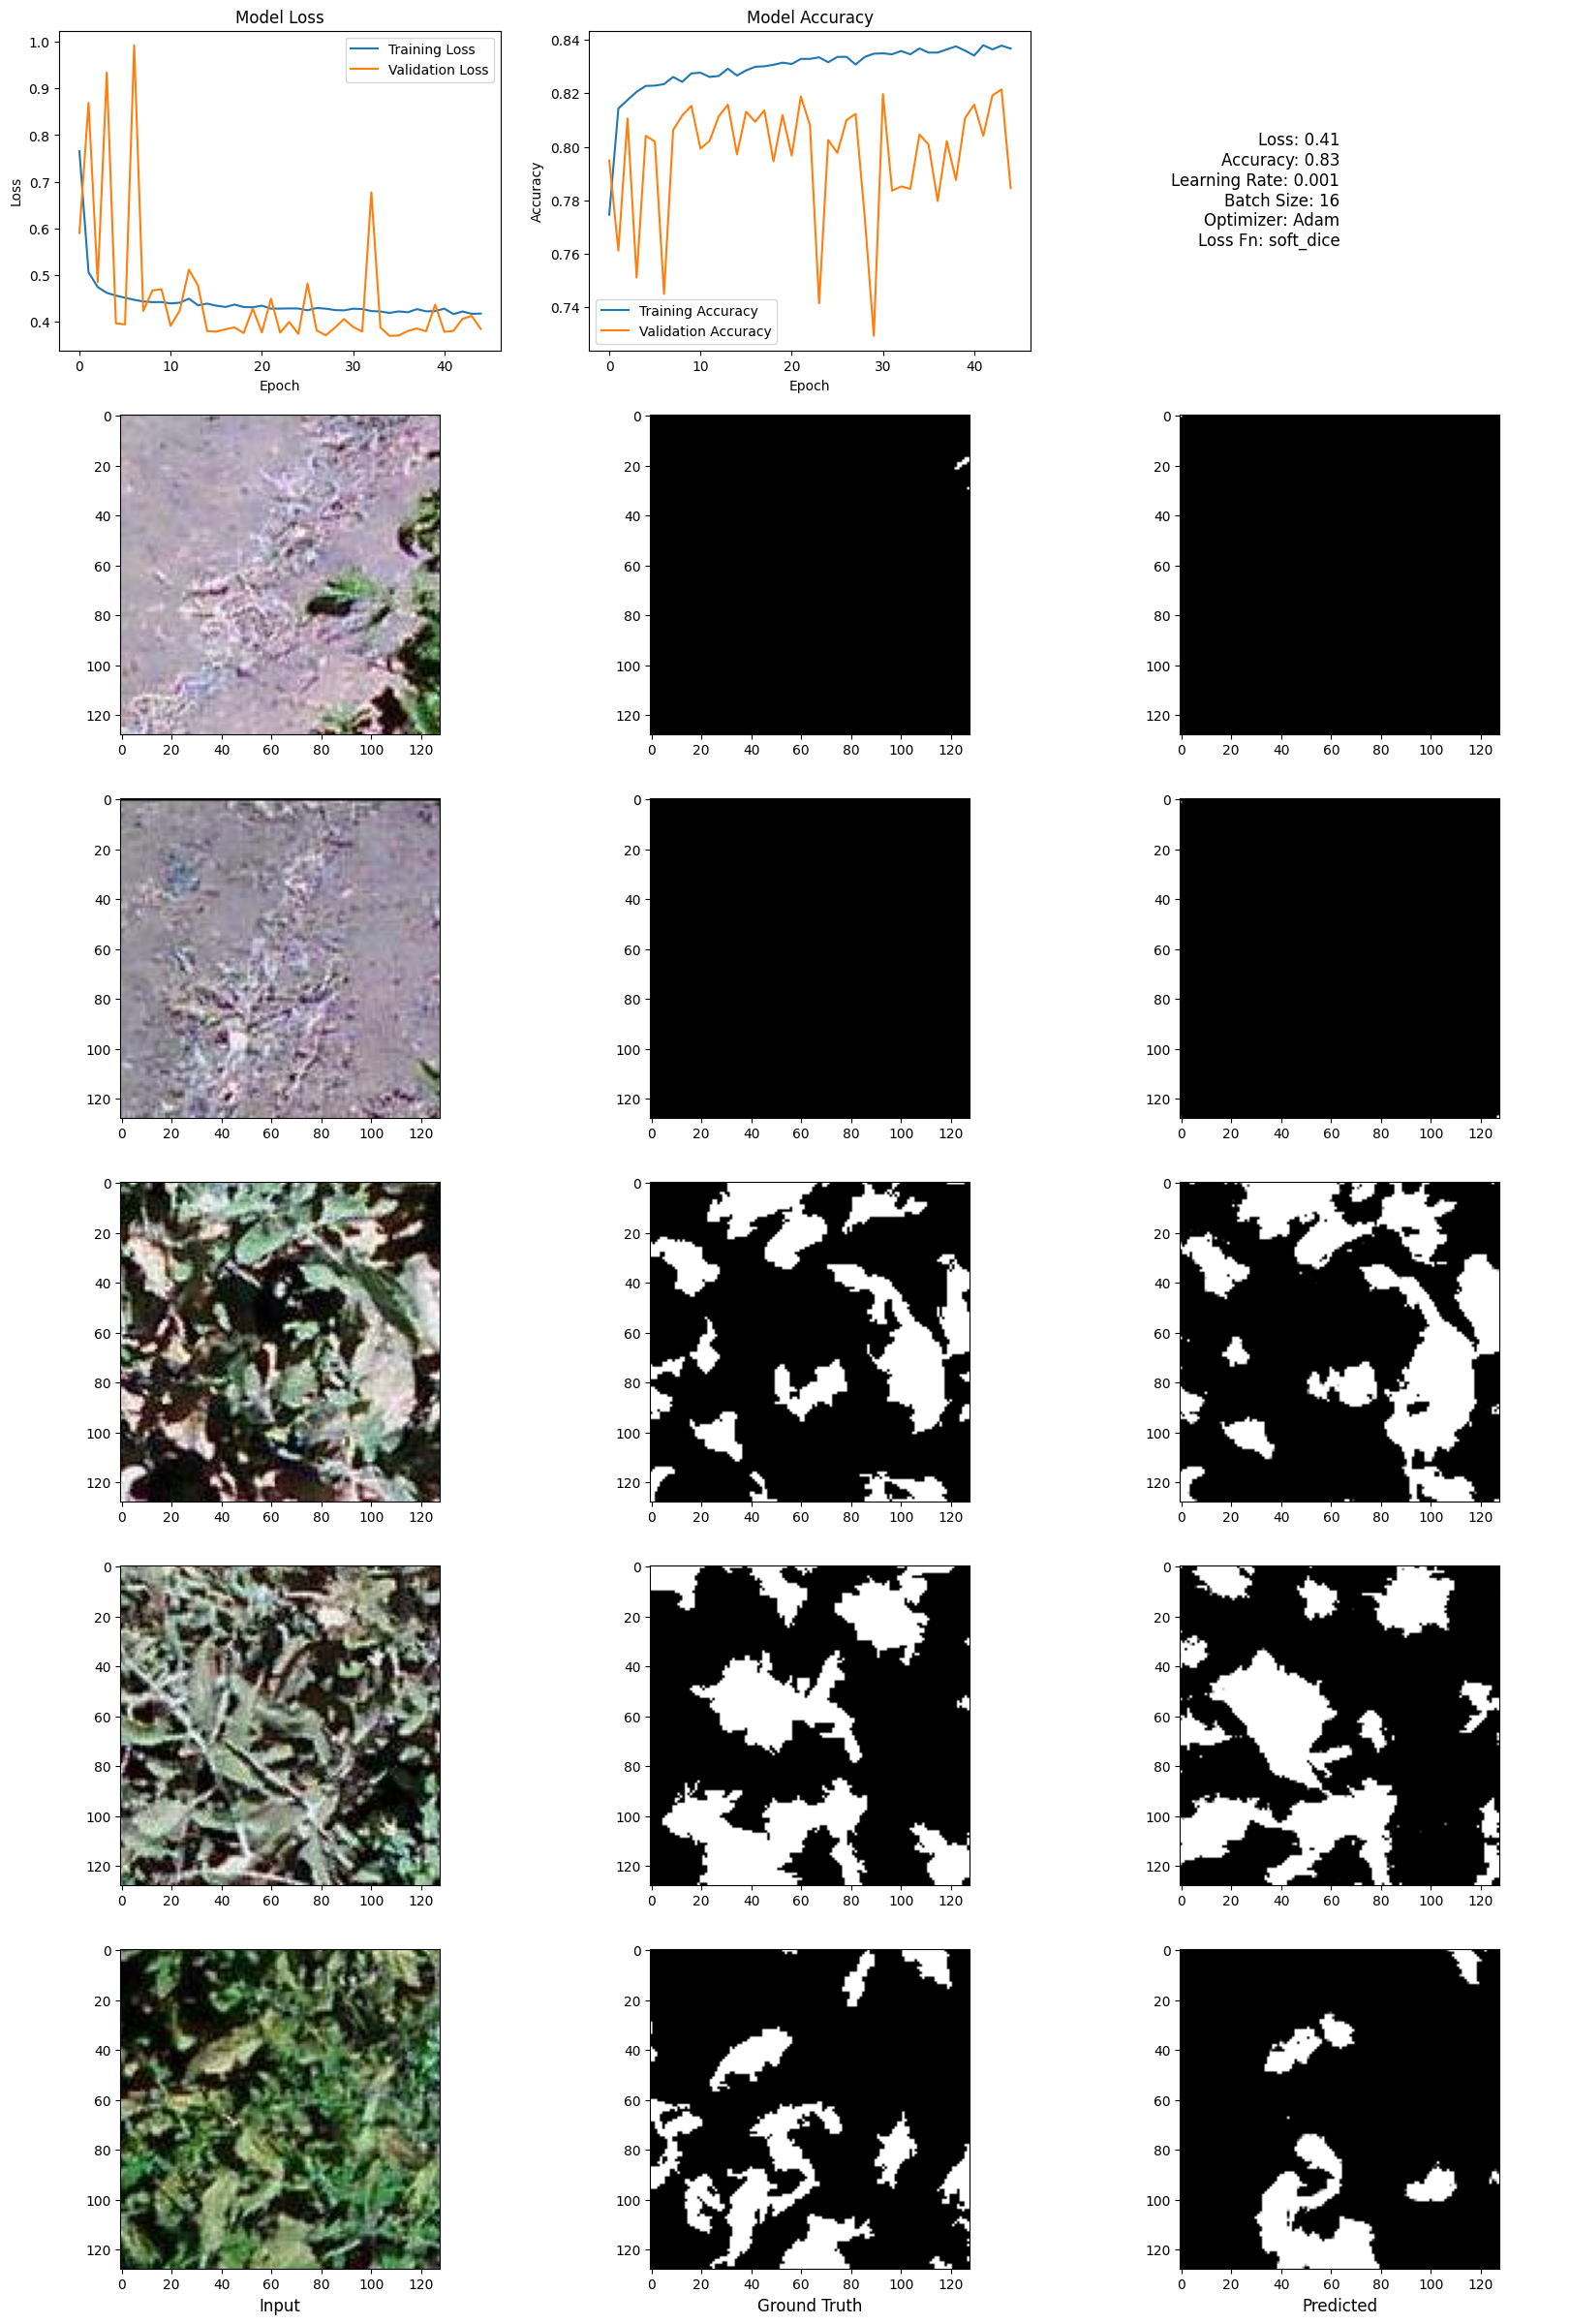

In [4]:
utils.analyzer(history, model, image_path, mask_path, test_images, test_masks, train_attr)